# Kaggle housing prices: Predicting prices of a new house based on the given data

### Borrows data exploration idea from the notebook on Kaggle by Pedro Marcelino

### Author: Sushant N. More

### Revision history: 
Sept. 8, 2017: started writing

Sept. 12, 2017: Merged from dev branch and cleaned the notebook

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

from scipy.stats import shapiro
from scipy.stats import norm
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score

First step: look at the data

In [2]:
train_df = pd.read_csv('./data/train.csv')

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


That's a lot of features! 

In [4]:
train_df.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'Pav

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Few quick observations: Many null values (>~ 80%) for Alley, Fence, MiscFeature. 
Also about 50% null values for FireplaceQu

In [6]:
train_df.shape

(1460, 81)

In [7]:
test_df = pd.read_csv('./data/test.csv')

In [8]:
test_df.shape

(1459, 80)

In [9]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
test_df.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'Pav

In [11]:
train_df.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'Pav

test_df as expected does not have the SalesPrice data

Let's look at what the distribution of the SalesPrice.  Use the cool describe function

In [12]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Plotting the salesprice. More exploration of the distplot function in dev branch. 

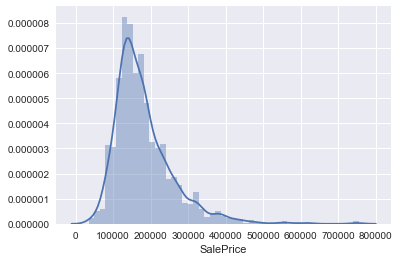

In [14]:
sns.distplot(train_df['SalePrice'], kde = True, norm_hist=True)

distplot combines the matplotlib hist function (with automatic calculation of a good default bin size) with the seaborn kdeplot() and rugplot() functions. It can also fit scipy.stats distributions and plot the estimated PDF over the data.

kdeplot
Show a univariate or bivariate distribution with a kernel density estimate.

rugplot
Draw small vertical lines to show each observation in a distribution.

We find that the distribution of the SalePrice has a long tail.  Not normally distributed.  To show off our statistics knowledge we use the Shapiro-Wilk test to see if the data is normally distributed.

In [15]:
shapiro(train_df['SalePrice'].values)

(0.869671642780304, 3.206247534576162e-33)

Since, the pvalue of Shapiro Wilk test is almost 0, we reject the Null hypothesis that the data was drawn from a normal distribution. 

Let's look at the skewness and kurtosis. 

Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.

Kurtosis of a standard normal distribution is 3. 

In [16]:
print "Skewness: %f" % train_df['SalePrice'].skew()
print "Kurtosis: %f" % train_df['SalePrice'].kurtosis()

Skewness: 1.882876
Kurtosis: 6.536282


** There are a ton of features here.  We will need to do some feature selection/ engineering.  Let's look at which features are the most correlated and which ones are the most relevant for the salesprice prediction ** 

In [17]:
corrmat = train_df.corr()

In [18]:
corrmat

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


Gives a correlation matrix of numerical qualities

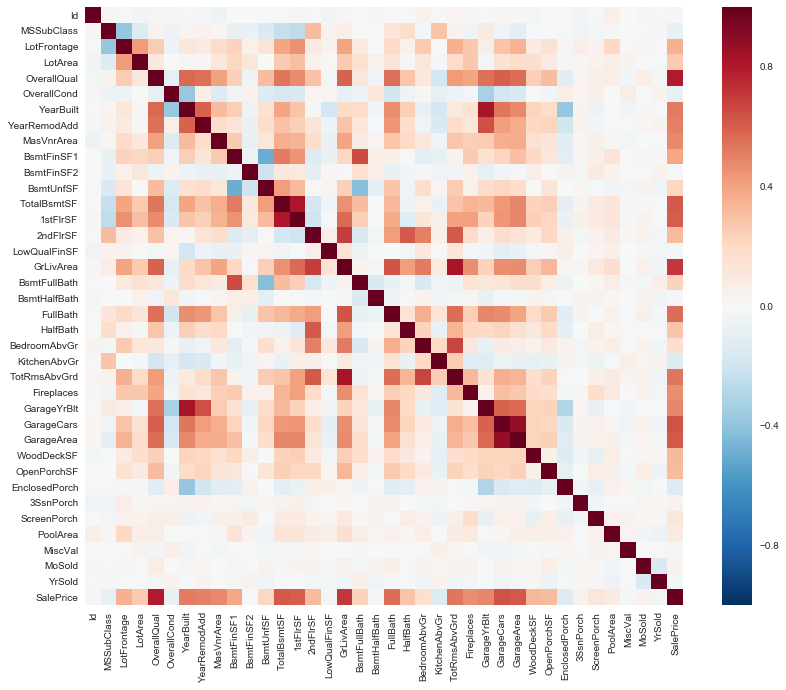

In [19]:
f, ax = plt.subplots(figsize = (14, 11))
sns.heatmap(corrmat, vmax = 1, square = True)

We find that the 'TotalBsmtSF' and '1stFlrSF' features are correlated.  Also find that all the Garage features are correlated.  Probably can do away with some of them in the spirit of getting rid of redundant features. 

From this plot we also find which features are most important for predicting the SalePrice.

Below, a nifty way to find out how many features belong to a particular category

In [20]:
train_df.select_dtypes(include = ['object']).columns

Index([u'MSZoning', u'Street', u'Alley', u'LotShape', u'LandContour',
       u'Utilities', u'LotConfig', u'LandSlope', u'Neighborhood',
       u'Condition1', u'Condition2', u'BldgType', u'HouseStyle', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinType2', u'Heating',
       u'HeatingQC', u'CentralAir', u'Electrical', u'KitchenQual',
       u'Functional', u'FireplaceQu', u'GarageType', u'GarageFinish',
       u'GarageQual', u'GarageCond', u'PavedDrive', u'PoolQC', u'Fence',
       u'MiscFeature', u'SaleType', u'SaleCondition'],
      dtype='object')

In [21]:
len(train_df.select_dtypes(include = ['object']).columns)

43

In [22]:
train_df.select_dtypes(include = ['float']).columns

Index([u'LotFrontage', u'MasVnrArea', u'GarageYrBlt'], dtype='object')

In [23]:
len(train_df.select_dtypes(include = ['float']).columns)

3

In [24]:
train_df.select_dtypes(include = ['int']).columns

Index([u'Id', u'MSSubClass', u'LotArea', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'BsmtFinSF1', u'BsmtFinSF2',
       u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath', u'FullBath',
       u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr', u'TotRmsAbvGrd',
       u'Fireplaces', u'GarageCars', u'GarageArea', u'WoodDeckSF',
       u'OpenPorchSF', u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch',
       u'PoolArea', u'MiscVal', u'MoSold', u'YrSold', u'SalePrice'],
      dtype='object')

In [25]:
len(train_df.select_dtypes(include = ['int']).columns)

35

In [26]:
len(train_df.select_dtypes(include = ['int']).columns) + len(train_df.select_dtypes(include = ['float']).columns) \
+ len(train_df.select_dtypes(include = ['object']).columns)

81

Back to look at correlations

In [27]:
corrmat.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982


In [28]:
corrmat.nlargest(9, 'SalePrice')['SalePrice']

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64

DataFrame.nlargest(n, columns, keep='first').
Get the rows of a DataFrame sorted by the n largest values of columns.

In [29]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

In [30]:
cols

Index([u'SalePrice', u'OverallQual', u'GrLivArea', u'GarageCars',
       u'GarageArea', u'TotalBsmtSF', u'1stFlrSF', u'FullBath',
       u'TotRmsAbvGrd', u'YearBuilt'],
      dtype='object')

In [31]:
cm = np.corrcoef(train_df[cols].values.T)

numpy.corrcoef() and .corr() do the same thing.  The only difference is in numpy.corrcoef(), the default option for rowvar is True.  This means that it treats each row as a variable (feature) with the column values as observations

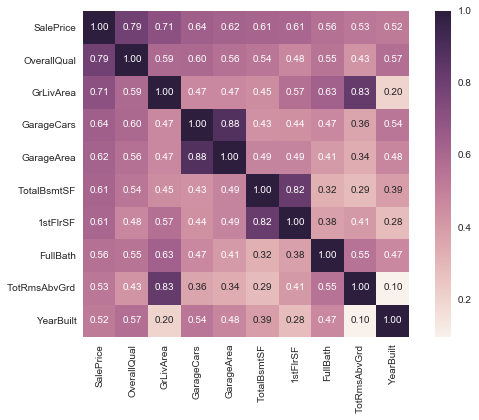

In [32]:
f, ax = plt.subplots(figsize = (9, 6))
sns.set(font_scale = 1)
sns.heatmap(cm, cbar = True, annot = True, square = True, fmt='.2f', \
            annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

Looking at the column of SalePrice, we can see which are the features that it most heavily depends on. 

All we find that some of these feature (e.g., GarageCars and GarageArea, and TotalBsmtSF and 1stFlrSF) are interdependent -- "twin brothers".  We can get rid of one of those.

Let's look at some scatter plots

In [33]:
cols

Index([u'SalePrice', u'OverallQual', u'GrLivArea', u'GarageCars',
       u'GarageArea', u'TotalBsmtSF', u'1stFlrSF', u'FullBath',
       u'TotRmsAbvGrd', u'YearBuilt'],
      dtype='object')

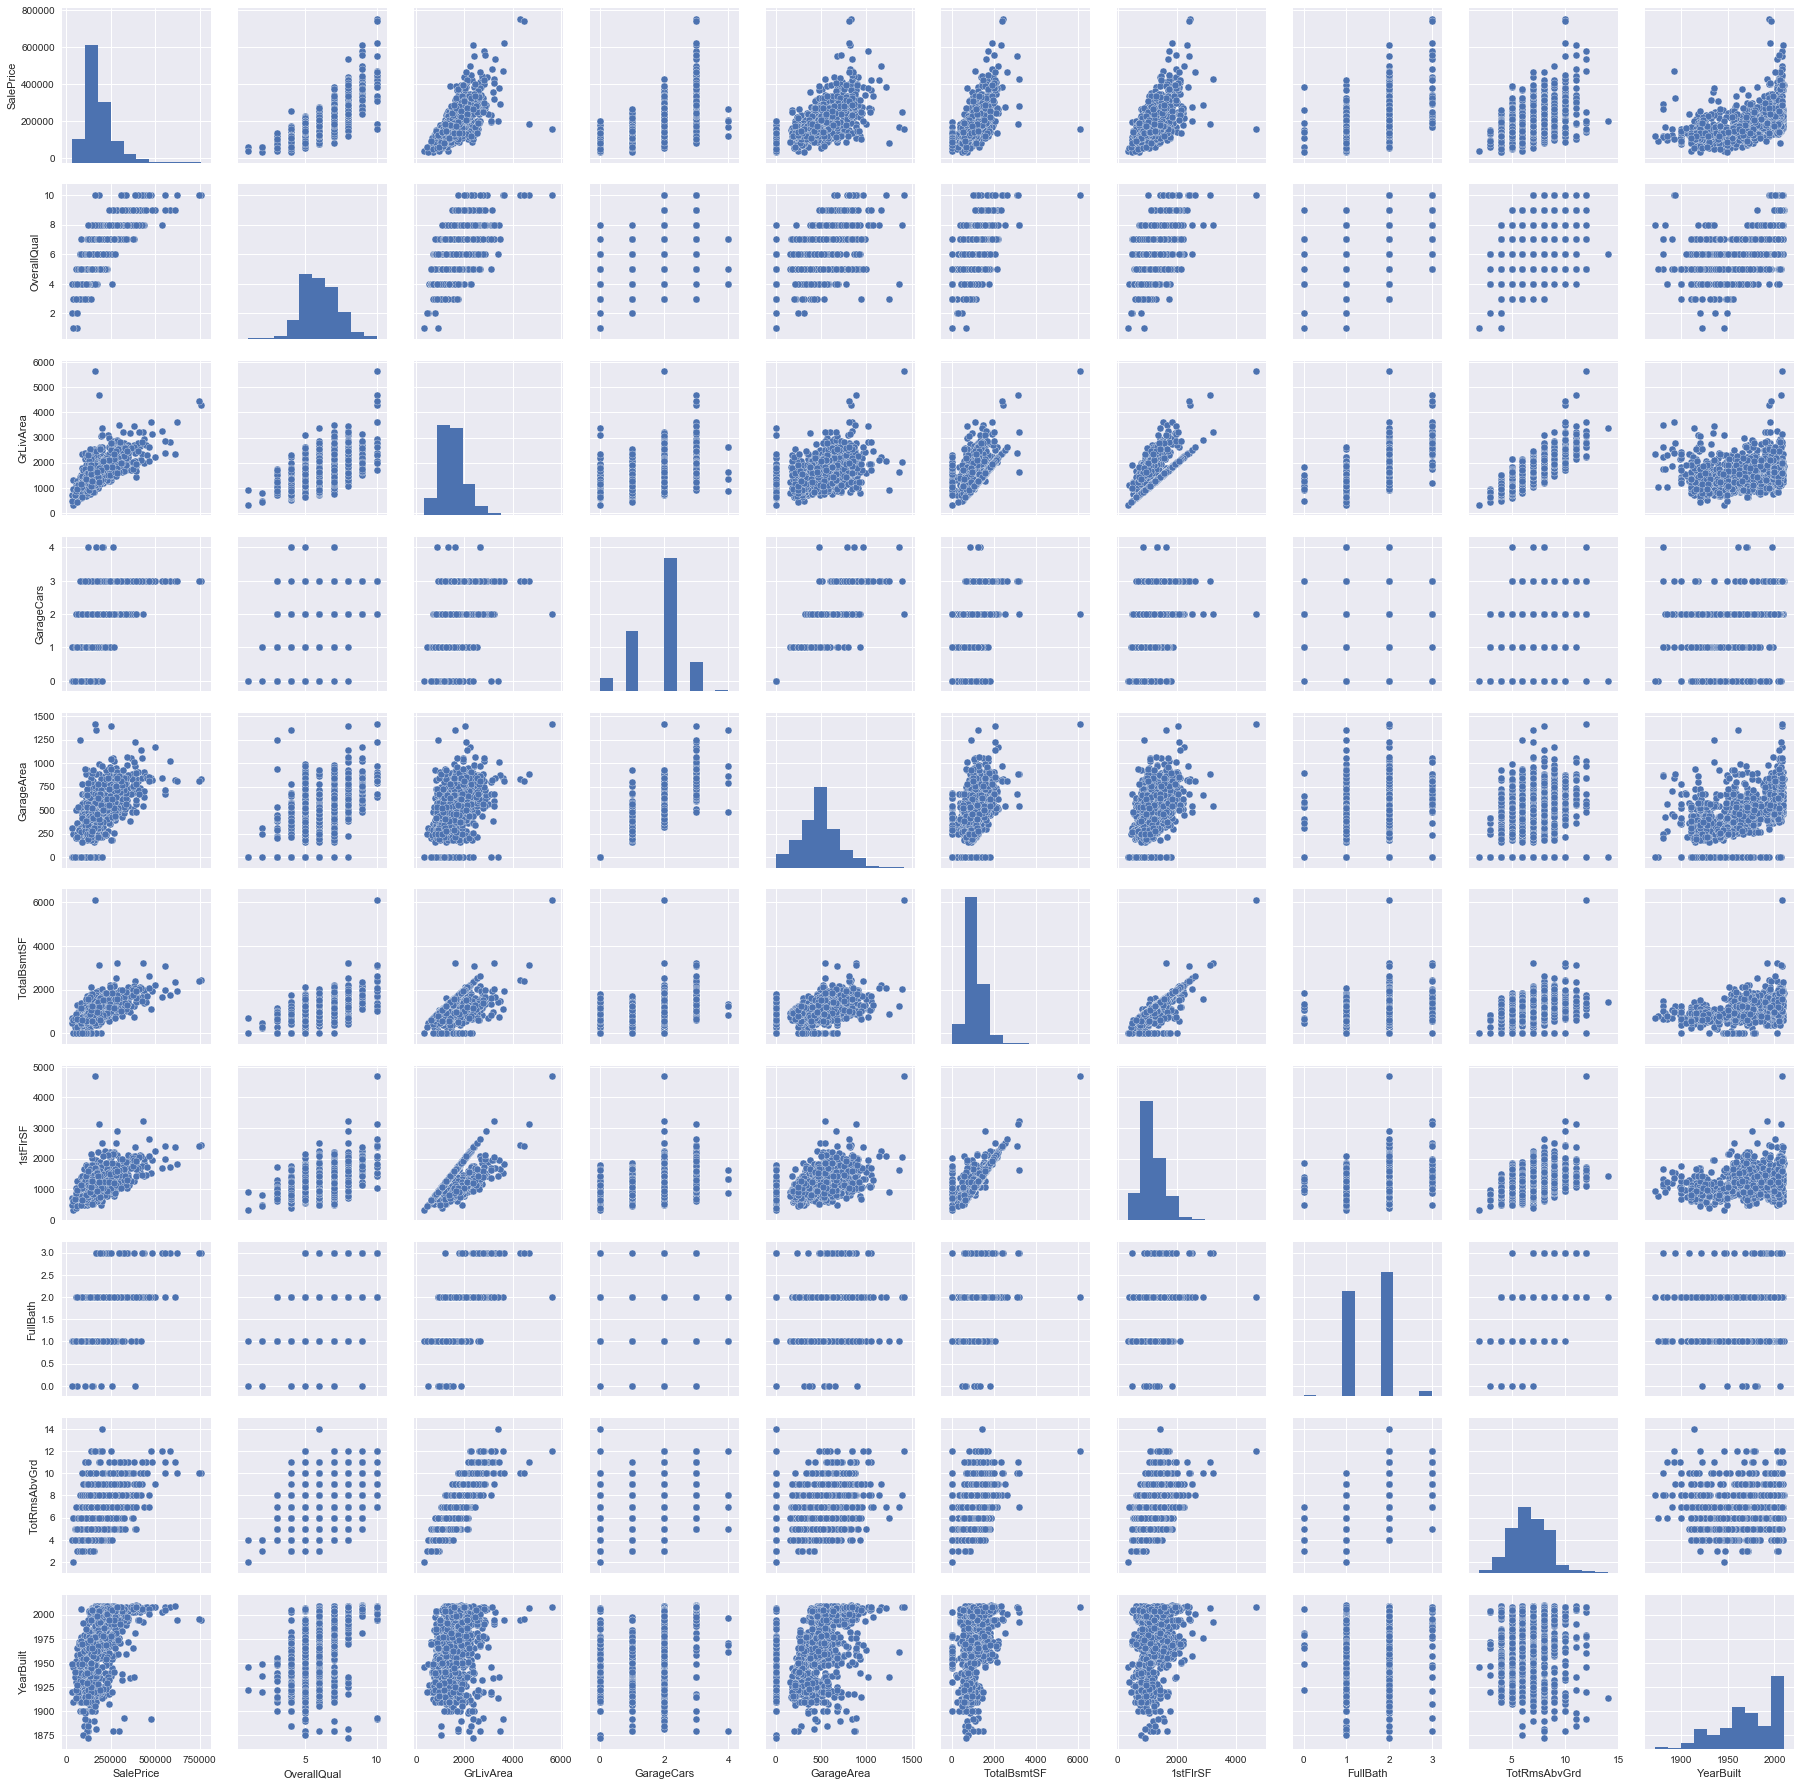

In [34]:
sns.pairplot(train_df[cols])

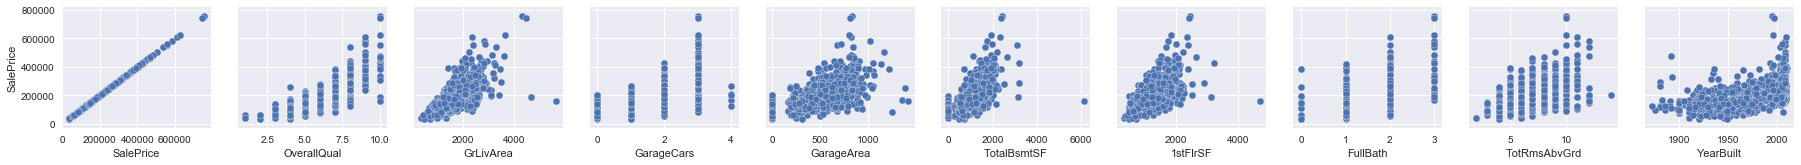

In [35]:
sns.pairplot(train_df[cols], x_vars = cols, y_vars = 'SalePrice', size = 2.5)

Let's look at some of the plots by themselves, starting with scatterplots for GrLiveArea and TotalBsmtSF

In [36]:
pd.concat([train_df.SalePrice, train_df.GrLivArea], axis = 1).head()

,SalePrice,GrLivArea
0,208500,1710
1,181500,1262
2,223500,1786
3,140000,1717
4,250000,2198


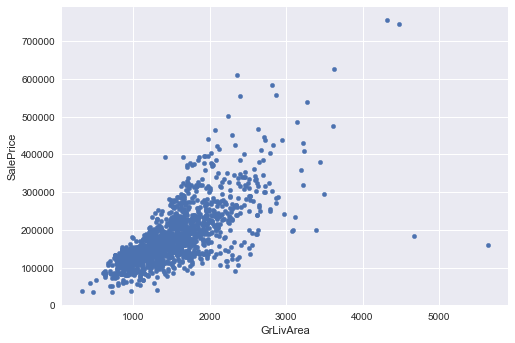

In [37]:
var = 'GrLivArea'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice')

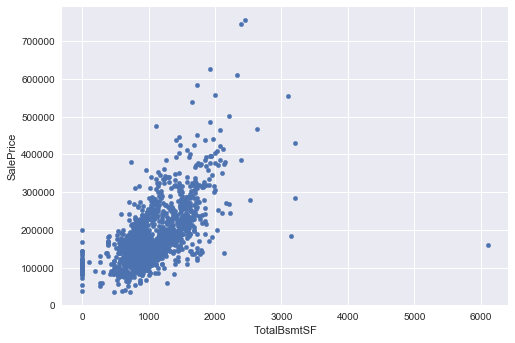

In [38]:
var = 'TotalBsmtSF'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice')

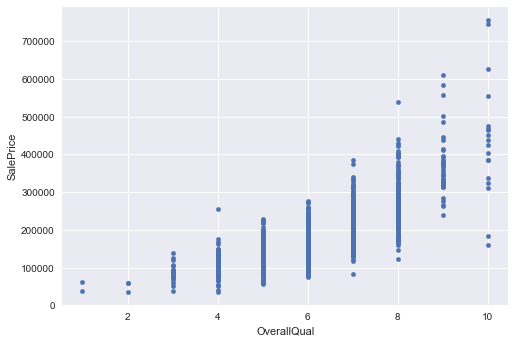

In [39]:
var = 'OverallQual'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice')

A better way to look at the categorical features is through box plot

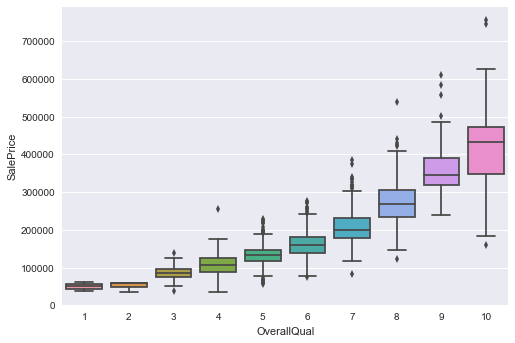

In [40]:
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data=train_df)

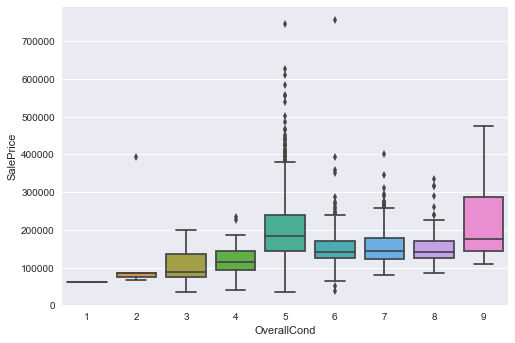

In [41]:
sns.boxplot(x = 'OverallCond', y = 'SalePrice', data=train_df)

The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.

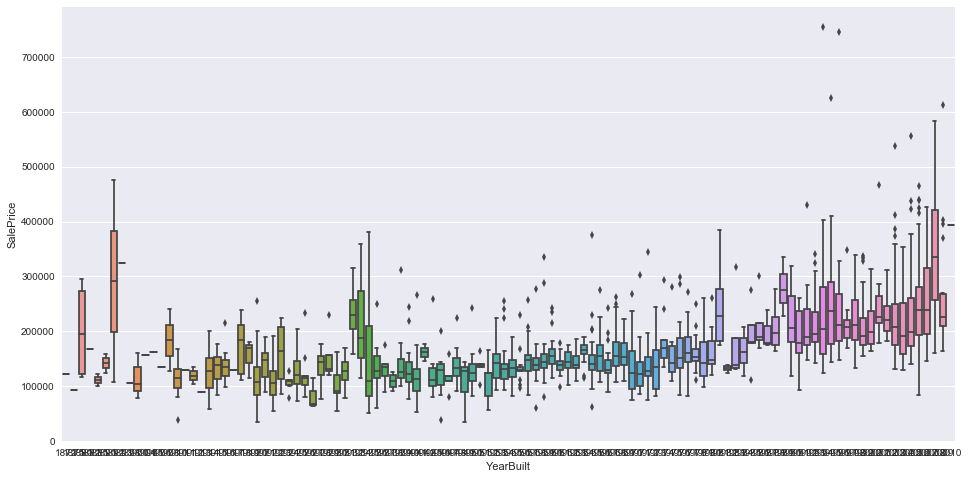

In [42]:
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x = 'YearBuilt', y = 'SalePrice', data=train_df)

In [43]:
np.sort(train_df.YearBuilt.values)

array([1872, 1875, 1880, ..., 2009, 2009, 2010])

In [44]:
np.sort(train_df.YearBuilt.unique())

array([1872, 1875, 1880, 1882, 1885, 1890, 1892, 1893, 1898, 1900, 1904,
       1905, 1906, 1908, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917,
       1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928,
       1929, 1930, 1931, 1932, 1934, 1935, 1936, 1937, 1938, 1939, 1940,
       1941, 1942, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010])

Conclusion: SalePrice definitely goes up with increasing GrLiveArea and TotalBsmtSF.  It only weakly goes up (if at all) with the YearBuilt 

## Taking care of missing data

In [45]:
train_df.isnull().sum().sort_values(ascending = False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

In [46]:
train_df.shape[0]

1460

In [47]:
total = train_df.isnull().sum().sort_values(ascending = False)
percent = train_df.isnull().sum().sort_values(ascending = False) / train_df.shape[0]
missingData = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent missing'])
missingData.head(20)

,Total,Percent missing
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [48]:
train_df.MasVnrArea.dtype

dtype('float64')

In [49]:
train_df.MasVnrType.dtype

dtype('O')

PoolQC, MiscFeature, Alley, Fence, and FireplaceQu have about 50% or more values missing.  No point in imputing.  Let's just drop these features.  Remember we gotta to drop the features from the test data as well so that later models are evaluated consistently

In [50]:
total_test = test_df.isnull().sum().sort_values(ascending = False)
percent_test = test_df.isnull().sum().sort_values(ascending = False) / test_df.shape[0]
missingDataTest = pd.concat([total_test, percent_test], axis = 1, keys = ['Total', 'Percent missing'])
missingDataTest.head(35)

,Total,Percent missing
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageYrBlt,78,0.053461
GarageFinish,78,0.053461


In [51]:
missingData[missingData['Percent missing'] > 0.4].index

Index([u'PoolQC', u'MiscFeature', u'Alley', u'Fence', u'FireplaceQu'], dtype='object')

In [52]:
combine_train_test = [train_df, test_df]

In [53]:
train_df_mod = train_df.drop(missingData[missingData['Percent missing'] > 0.4].index, axis = 1)  
test_df_mod = test_df.drop(missingData[missingData['Percent missing'] > 0.4].index, axis = 1)

In [54]:
train_df_mod.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


We also saw before that GarageArea and GarageCars had a high correlation.  So did, TotalBsmtSF and 1stFlrSF. 

Let's look at the scatter plots before eliminating one of the twin brothers. 

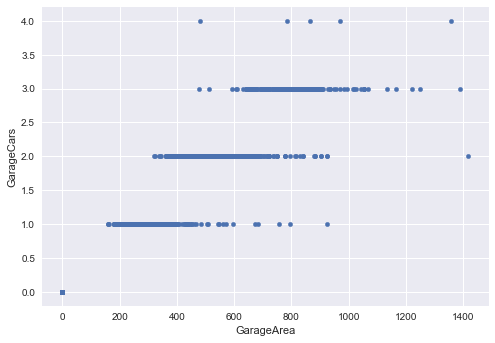

In [55]:
train_df_mod.plot.scatter(x = 'GarageArea', y = 'GarageCars')

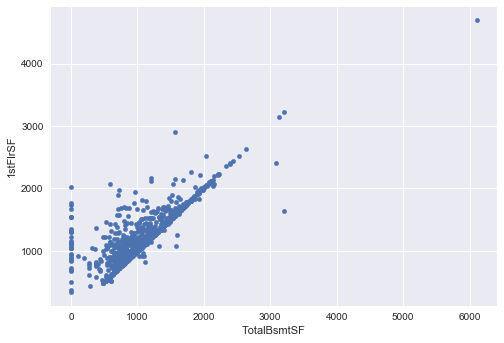

In [56]:
train_df_mod.plot.scatter(x = 'TotalBsmtSF', y = '1stFlrSF')

If there was not the line at y=0.  We could have eliminated one feature in the favor of another. Let's keep the features for now. Come back after the outliers are dealt with.  

Let's look at the features which didn't contribute much to the salePrice and drop them.  As you can see, I am bent on dropping features

In [57]:
corrmat = train_df.corr()

In [58]:
corrmat.nlargest(81, 'SalePrice')['SalePrice']

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [59]:
corr_values = corrmat.nlargest(81, 'SalePrice')['SalePrice']

In [60]:
corr_values[(corr_values < 0.04) & (corr_values > - 0.03)]

BsmtFinSF2     -0.011378
BsmtHalfBath   -0.016844
MiscVal        -0.021190
Id             -0.021917
LowQualFinSF   -0.025606
YrSold         -0.028923
Name: SalePrice, dtype: float64

In [61]:
bad_features = corr_values[(corr_values < 0.04) & (corr_values > - 0.03)].index
bad_features

Index([u'BsmtFinSF2', u'BsmtHalfBath', u'MiscVal', u'Id', u'LowQualFinSF',
       u'YrSold'],
      dtype='object')

In [62]:
bad_features = bad_features[bad_features != 'Id']

In [63]:
bad_features

Index([u'BsmtFinSF2', u'BsmtHalfBath', u'MiscVal', u'LowQualFinSF', u'YrSold'], dtype='object')

In [64]:
train_df_mod2 = train_df_mod.drop(bad_features, axis = 1)

In [65]:
test_df_mod2 = test_df_mod.drop(bad_features, axis = 1)

In [66]:
train_df_mod2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,61,0,0,0,0,2,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,298,0,0,0,0,0,5,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,42,0,0,0,0,9,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,35,272,0,0,0,2,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,192,84,0,0,0,0,12,WD,Normal,250000


Let's again look at the missing values, with these dropped features

In [67]:
total_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False)
percent_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False) / test_df_mod2.shape[0]
missingDataTest_mod2 = pd.concat([total_test_mod2, percent_test_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTest_mod2.head(30)

,Total,Percent missing
LotFrontage,227,0.155586
GarageQual,78,0.053461
GarageYrBlt,78,0.053461
GarageFinish,78,0.053461
GarageCond,78,0.053461
GarageType,76,0.052090
BsmtCond,45,0.030843
BsmtQual,44,0.030158
BsmtExposure,44,0.030158
BsmtFinType2,42,0.028787


In [68]:
total_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False)
percent_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False) / train_df_mod2.shape[0]
missingDataTrain_mod2 = pd.concat([total_train_mod2, percent_train_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTrain_mod2.head(20)

,Total,Percent missing
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageQual,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
BsmtExposure,38,0.026027
BsmtFinType2,38,0.026027
BsmtQual,37,0.025342
BsmtFinType1,37,0.025342


In [69]:
train_df_mod2.loc[~train_df_mod2.GarageQual.isnull()][['Id', 'GarageCond', 'GarageQual', 'GarageType', \
                                                       'GarageYrBlt']]

,Id,GarageCond,GarageQual,GarageType,GarageYrBlt
0,1,TA,TA,Attchd,2003.0
1,2,TA,TA,Attchd,1976.0
2,3,TA,TA,Attchd,2001.0
3,4,TA,TA,Detchd,1998.0
4,5,TA,TA,Attchd,2000.0
5,6,TA,TA,Attchd,1993.0
6,7,TA,TA,Attchd,2004.0
7,8,TA,TA,Attchd,1973.0
8,9,TA,Fa,Detchd,1931.0
9,10,TA,Gd,Attchd,1939.0


We now know which variables have null values and need to be imputed.  Let's just look at them one by one.  Starting with the LotFrontage.  Let's start by seeing which other features are correlated with LotFrontage

In [70]:
corrmat.nlargest(9, 'LotFrontage')['LotFrontage']

LotFrontage     1.000000
1stFlrSF        0.457181
LotArea         0.426095
GrLivArea       0.402797
TotalBsmtSF     0.392075
TotRmsAbvGrd    0.352096
SalePrice       0.351799
GarageArea      0.344997
GarageCars      0.285691
Name: LotFrontage, dtype: float64

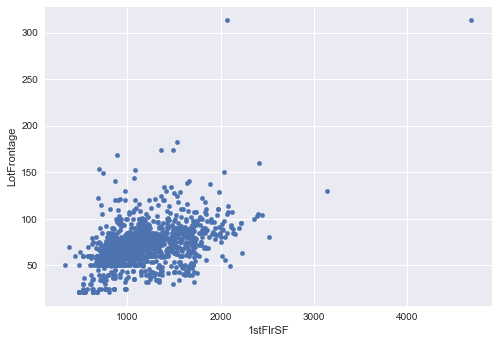

In [71]:
train_df.plot.scatter(y = 'LotFrontage',  x = '1stFlrSF')

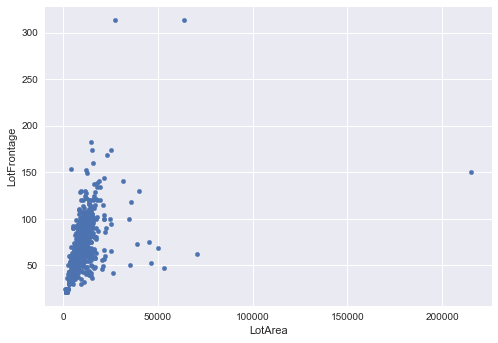

In [72]:
train_df.plot.scatter(y = 'LotFrontage',  x = 'LotArea')

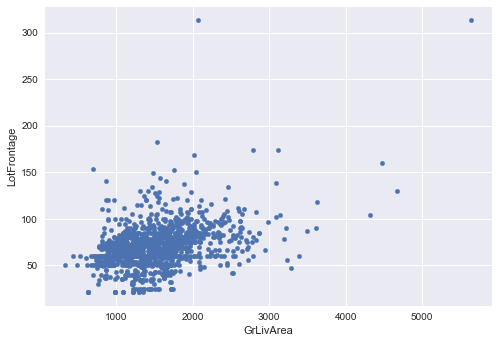

In [73]:
train_df.plot.scatter(y = 'LotFrontage',  x = 'GrLivArea')

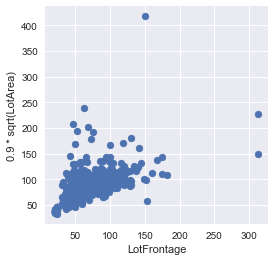

In [74]:
plt.figure(figsize = (4,4))
plt.scatter(train_df['LotFrontage'], 0.9* np.sqrt(train_df['LotArea']))
plt.xlabel('LotFrontage')
plt.ylabel('0.9 * sqrt(LotArea)')

A good imputation strategy for LotFrontage is to replace it with 0.9 * \sqrt{LotArea}

In [75]:
train_df_mod2.loc[train_df_mod2['LotFrontage'].isnull()].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,SaleType,SaleCondition,SalePrice
7,8,60,RL,NaN,10382,Pave,IR1,Lvl,AllPub,Corner,...,235,204,228,0,0,0,11,WD,Normal,200000
12,13,20,RL,NaN,12968,Pave,IR2,Lvl,AllPub,Inside,...,140,0,0,0,176,0,9,WD,Normal,144000
14,15,20,RL,NaN,10920,Pave,IR1,Lvl,AllPub,Corner,...,0,213,176,0,0,0,5,WD,Normal,157000
16,17,20,RL,NaN,11241,Pave,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,0,0,3,WD,Normal,149000
24,25,20,RL,NaN,8246,Pave,IR1,Lvl,AllPub,Inside,...,406,90,0,0,0,0,5,WD,Normal,154000


In [76]:
train_df_mod2.loc[train_df_mod2['LotFrontage'].isnull(), 'LotFrontage'] = 0.9 * np.sqrt(train_df_mod2['LotArea'])

In [78]:
test_df_mod2.loc[test_df_mod2['LotFrontage'].isnull(), 'LotFrontage'] = 0.9 * np.sqrt(test_df_mod2['LotArea'])

In [79]:
total_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False)
percent_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False) / train_df_mod2.shape[0]
missingDataTrain_mod2 = pd.concat([total_train_mod2, percent_train_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTrain_mod2.head(15)

,Total,Percent missing
GarageCond,81,0.055479
GarageQual,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
BsmtExposure,38,0.026027
BsmtFinType2,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342


Below, trying to get a feel for values in the columns

In [80]:
train_df_mod2['GarageCond'].unique()

array(['TA', 'Fa', nan, 'Gd', 'Po', 'Ex'], dtype=object)

In [81]:
train_df_mod2['GarageQual'].unique()

array(['TA', 'Fa', 'Gd', nan, 'Ex', 'Po'], dtype=object)

In [82]:
train_df_mod2['GarageType'].unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'], dtype=object)

In [83]:
train_df_mod2['GarageFinish'].unique()

array(['RFn', 'Unf', 'Fin', nan], dtype=object)

Scatter plot needs two X and Y values to be numerical, the boxplot needs at least one of the X, Y values to be numerical 

In [84]:
train_df_mod2[['GarageCond', 'GarageQual', 'GarageType', 'GarageFinish', 'GarageYrBlt']].head(10)

,GarageCond,GarageQual,GarageType,GarageFinish,GarageYrBlt
0,TA,TA,Attchd,RFn,2003.0
1,TA,TA,Attchd,RFn,1976.0
2,TA,TA,Attchd,RFn,2001.0
3,TA,TA,Detchd,Unf,1998.0
4,TA,TA,Attchd,RFn,2000.0
5,TA,TA,Attchd,Unf,1993.0
6,TA,TA,Attchd,RFn,2004.0
7,TA,TA,Attchd,RFn,1973.0
8,TA,Fa,Detchd,Unf,1931.0
9,TA,Gd,Attchd,RFn,1939.0


In [85]:
train_df_mod2.loc[train_df_mod2['GarageCond'].isnull()]\
[['GarageCond','GarageQual', 'GarageType', 'GarageFinish', 'GarageYrBlt', 'GarageCars', 'GarageArea']].head(7)

,GarageCond,GarageQual,GarageType,GarageFinish,GarageYrBlt,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0,0
48,NaN,NaN,NaN,NaN,NaN,0,0
78,NaN,NaN,NaN,NaN,NaN,0,0
88,NaN,NaN,NaN,NaN,NaN,0,0
89,NaN,NaN,NaN,NaN,NaN,0,0
99,NaN,NaN,NaN,NaN,NaN,0,0
108,NaN,NaN,NaN,NaN,NaN,0,0


The data description file says that the NA value in Garage fields, means that the Garage doesn't exist. Cool, now we know how to impute :)

In [86]:
combine_mod2 = [train_df_mod2, test_df_mod2]

In [87]:
for dataset in combine_mod2:
    dataset['GarageType'] = dataset['GarageType'].fillna("No")
    dataset['GarageFinish'] = dataset['GarageFinish'].fillna("No")
    dataset['GarageQual'] = dataset['GarageQual'].fillna("No")
    dataset['GarageCond'] = dataset['GarageCond'].fillna("No")
    dataset['GarageArea'] = dataset['GarageArea'].fillna("0")
    dataset['GarageCars'] = dataset['GarageCars'].fillna("0")

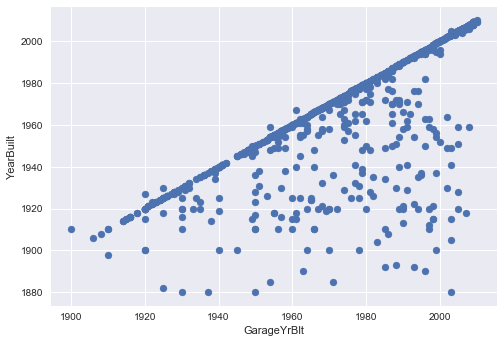

In [88]:
plt.scatter(train_df_mod2['GarageYrBlt'], train_df_mod2['YearBuilt'])
plt.xlabel('GarageYrBlt')
plt.ylabel('YearBuilt')

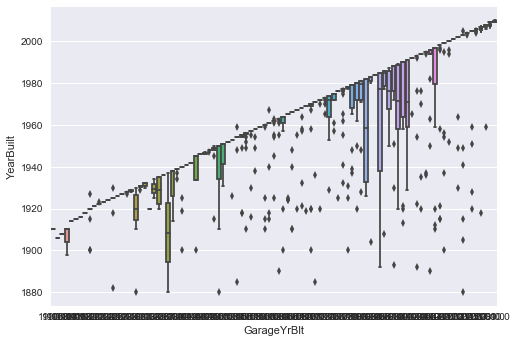

In [89]:
sns.boxplot(x = 'GarageYrBlt', y = 'YearBuilt', data=train_df_mod2)

I've a feeling that setting the 'GarageYrBuilt' to 0 in the cases, where Garage is not there might be a bit hard on our learning algorithms.  In the cases that the Garage is absent, I'll just replace the 'GarageYrBuilt' with the year that house was built. 

In [90]:
train_df_mod2.loc[train_df_mod2['GarageYrBlt'].isnull(), 'GarageYrBlt'] = train_df_mod2['YearBuilt']
test_df_mod2.loc[test_df_mod2['GarageYrBlt'].isnull(), 'GarageYrBlt'] = test_df_mod2['YearBuilt']

In [91]:
total_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False)
percent_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False) / train_df_mod2.shape[0]
missingDataTrain_mod2 = pd.concat([total_train_mod2, percent_train_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTrain_mod2.head(10)

,Total,Percent missing
BsmtExposure,38,0.026027
BsmtFinType2,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342
MasVnrArea,8,0.005479
MasVnrType,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000
Exterior1st,0,0.000000


In [92]:
total_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False)
percent_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False) / test_df_mod2.shape[0]
missingDataTest_mod2 = pd.concat([total_test_mod2, percent_test_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTest_mod2.head(20)

,Total,Percent missing
BsmtCond,45,0.030843
BsmtQual,44,0.030158
BsmtExposure,44,0.030158
BsmtFinType1,42,0.028787
BsmtFinType2,42,0.028787
MasVnrType,16,0.010966
MasVnrArea,15,0.010281
MSZoning,4,0.002742
BsmtFullBath,2,0.001371
Utilities,2,0.001371


All the garage related null variables are taken care of.

Similarly Nan in Basement related features means basement doesn't exist.

In [93]:
for dataset in combine_mod2:
    dataset['BsmtQual'] = dataset['BsmtQual'].fillna("No")
    dataset['BsmtCond'] = dataset['BsmtCond'].fillna("No")
    dataset['BsmtExposure'] = dataset['BsmtExposure'].fillna("No")
    dataset['BsmtFinType1'] = dataset['BsmtFinType1'].fillna("No")
    dataset['BsmtFinType2'] = dataset['BsmtFinType2'].fillna("No")
    dataset['BsmtFullBath'] = dataset['BsmtFullBath'].fillna(0)
    dataset['BsmtFinSF1'] = dataset['BsmtFinSF1'].fillna(0)
    dataset['BsmtUnfSF'] = dataset['BsmtUnfSF'].fillna(0)
    dataset['TotalBsmtSF'] = dataset['TotalBsmtSF'].fillna(0)

In [94]:
train_df_mod2['TotalBsmtSF'].dtype

dtype('int64')

In [95]:
train_df_mod2['BsmtUnfSF'].dtype

dtype('int64')

In [96]:
train_df_mod2['BsmtFullBath'].dtype

dtype('int64')

In [97]:
total_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False)
percent_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False) / test_df_mod2.shape[0]
missingDataTest_mod2 = pd.concat([total_test_mod2, percent_test_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTest_mod2.head(12)

,Total,Percent missing
MasVnrType,16,0.010966
MasVnrArea,15,0.010281
MSZoning,4,0.002742
Functional,2,0.001371
Utilities,2,0.001371
Exterior2nd,1,0.000685
Exterior1st,1,0.000685
KitchenQual,1,0.000685
SaleType,1,0.000685
LandContour,0,0.000000


In [98]:
total_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False)
percent_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False) / train_df_mod2.shape[0]
missingDataTrain_mod2 = pd.concat([total_train_mod2, percent_train_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTrain_mod2.head(5)

,Total,Percent missing
MasVnrArea,8,0.005479
MasVnrType,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000
YearRemodAdd,0,0.000000


All the basement related null variables are taken care of

In [99]:
train_df_mod2['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [100]:
train_df_mod2['MasVnrArea'].unique()[0:10]

array([ 196.,    0.,  162.,  350.,  186.,  240.,  286.,  306.,  212.,  180.])

In [101]:
train_df_mod2.loc[train_df_mod2['MasVnrType'].isnull()][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [102]:
test_df_mod2.loc[test_df_mod2['MasVnrType'].isnull()][['Id','MasVnrType', 'MasVnrArea']]

,Id,MasVnrType,MasVnrArea
231,1692,NaN,NaN
246,1707,NaN,NaN
422,1883,NaN,NaN
532,1993,NaN,NaN
544,2005,NaN,NaN
581,2042,NaN,NaN
851,2312,NaN,NaN
865,2326,NaN,NaN
880,2341,NaN,NaN
889,2350,NaN,NaN


In [103]:
test_df_mod2.loc[test_df_mod2['Id'] == 2611,'MasVnrType'] = 'BrkFace'

In [104]:
test_df_mod2.loc[test_df_mod2['Id'] == 2611]['MasVnrType']

1150    BrkFace
Name: MasVnrType, dtype: object

In [105]:
test_df_mod2.loc[test_df_mod2['Id'] == 2611]['MasVnrArea']

1150    198.0
Name: MasVnrArea, dtype: float64

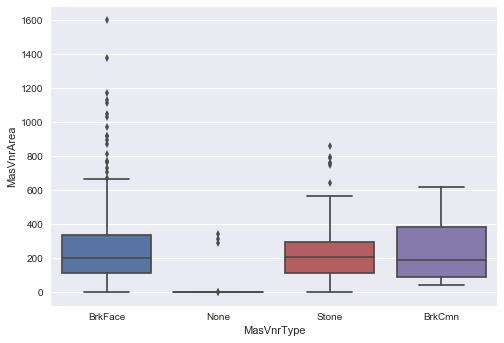

In [106]:
sns.boxplot(x = 'MasVnrType', y = 'MasVnrArea', data=train_df_mod2)

In [107]:
train_df_mod2['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

Since, none is the mode, we replace the missing values for MasVnrType with None and the corresponding values for MasVnrArea with 0.  We make an exception for the entry in the test data which has a missing value for the MasVnrType and a value of 198 for MasVnrArea.  For that entry we set the MasVnrType to BrkFace, the second most common. 

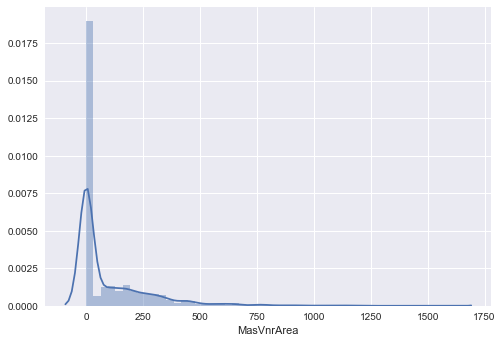

In [108]:
sns.distplot(train_df_mod2[train_df_mod2['MasVnrArea'].notnull()]['MasVnrArea'])

In [109]:
for dataset in combine_mod2:
   
    dataset['MasVnrType'] = dataset['MasVnrType'].fillna('None')
    dataset['MasVnrArea'] = dataset['MasVnrArea'].fillna(0)
   

In [110]:
total_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False)
percent_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False) / test_df_mod2.shape[0]
missingDataTest_mod2 = pd.concat([total_test_mod2, percent_test_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTest_mod2.head(8)

,Total,Percent missing
MSZoning,4,0.002742
Functional,2,0.001371
Utilities,2,0.001371
Exterior2nd,1,0.000685
Exterior1st,1,0.000685
KitchenQual,1,0.000685
SaleType,1,0.000685
LotShape,0,0.000000


In [111]:
total_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False)
percent_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False) / train_df_mod2.shape[0]
missingDataTrain_mod2 = pd.concat([total_train_mod2, percent_train_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTrain_mod2.head(5)

,Total,Percent missing
Electrical,1,0.000685
SalePrice,0,0.000000
MasVnrArea,0,0.000000
YearRemodAdd,0,0.000000
RoofStyle,0,0.000000


** Missing values in MasVnrArea and MasVnrType taken care of **

In [112]:
train_df_mod2['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [113]:
train_df_mod2['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [114]:
train_df_mod2['Functional'].value_counts()

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [115]:
train_df_mod2['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [116]:
train_df_mod2['Exterior2nd'].value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [117]:
train_df_mod2['Exterior1st'].value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64

In [118]:
train_df_mod2['KitchenQual'].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

In [119]:
train_df_mod2['SaleType'].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

Electrical, MSZoning, Functional, Utilities, Exterior2nd, Exterior1st, KitchenQual, SaleType all have one value which is much more prevalent than the other values.  So use that value to impute

In [128]:
test_df_mod2.loc[test_df_mod2['Utilities'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,SaleType,SaleCondition
455,1916,30,NaN,109.00000,21780,Grvl,Reg,Lvl,NaN,Inside,...,N,119,24,0,0,0,0,3,ConLD,Normal
485,1946,20,RL,159.02264,31220,Pave,IR1,Bnk,NaN,FR2,...,Y,0,0,144,0,0,0,5,WD,Normal


I'd have thought that the sklearn's imputer for the 'most_frequent' case would work with strings.  That doesn't seem to the same.  Just impute each feature by hand. 

In [129]:
for dataset in combine_mod2:
   
    dataset['Electrical'] = dataset['Electrical'].fillna('SbrKr')
    dataset['MSZoning'] = dataset['MSZoning'].fillna('RL')
    dataset['Functional'] = dataset['Functional'].fillna('Typ')
    dataset['Utilities'] = dataset['Utilities'].fillna('AllPub')
    dataset['Exterior2nd'] = dataset['Exterior2nd'].fillna('VinylSd')
    dataset['Exterior1st'] = dataset['Exterior1st'].fillna('VinylSd')
    dataset['KitchenQual'] = dataset['KitchenQual'].fillna('TA')
    dataset['SaleType'] = dataset['SaleType'].fillna('WD')
    

In [130]:
total_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False)
percent_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False) / train_df_mod2.shape[0]
missingDataTrain_mod2 = pd.concat([total_train_mod2, percent_train_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTrain_mod2.head(3)

,Total,Percent missing
SalePrice,0,0.0
MasVnrArea,0,0.0
YearRemodAdd,0,0.0


In [131]:
total_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False)
percent_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False) / test_df_mod2.shape[0]
missingDataTest_mod2 = pd.concat([total_test_mod2, percent_test_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTest_mod2.head(3)

,Total,Percent missing
SaleCondition,0,0.0
MasVnrArea,0,0.0
YearRemodAdd,0,0.0


All missing features taken care off

In [132]:
train_df_mod2.isnull().sum().max()

0

In [133]:
test_df_mod2.isnull().sum().max()

0

Confirming again that all missing values are taken care of.

## Dealing with outliers

In [134]:
salepriceScaled = preprocessing.StandardScaler().fit_transform(train_df['SalePrice'][:,np.newaxis]);

/home/sushant/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [135]:
salepriceScaled

array([[ 0.34727322],
       [ 0.00728832],
       [ 0.53615372],
       ..., 
       [ 1.07761115],
       [-0.48852299],
       [-0.42084081]])

In [136]:
train_df['SalePrice'].head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [137]:
train_df['SalePrice'][np.newaxis, :]

array([[208500, 181500, 223500, ..., 266500, 142125, 147500]])

The newaxis object can be used in all slicing operations to create an axis of length one. newaxis is an alias for ‘None’, and ‘None’ can be used in place of this with the same result.

In [139]:
preprocessing.StandardScaler().fit_transform(train_df['SalePrice'][:,np.newaxis])

array([[ 0.34727322],
       [ 0.00728832],
       [ 0.53615372],
       ..., 
       [ 1.07761115],
       [-0.48852299],
       [-0.42084081]])

In [140]:
preprocessing.StandardScaler().fit(train_df['SalePrice'][:,np.newaxis]).mean_

array([ 180921.19589041])

In [143]:
preprocessing.StandardScaler().fit(train_df['SalePrice'][:,np.newaxis]).scale_
# scale gives the standard deviation

array([ 79415.29188607])

In [144]:
salepriceScaled = preprocessing.StandardScaler().fit_transform(train_df['SalePrice'][:,np.newaxis])

In [145]:
low_range = salepriceScaled[salepriceScaled[:,0].argsort()][:10] 
#keeping this line here just to show the use of argsort
low_range = np.sort(salepriceScaled[:, 0])[:10]

In [146]:
high_range = np.sort(salepriceScaled[:, 0])[-10:]

In [147]:
print('outer range (low) of the distribution:')
print(low_range)
print('\n outer range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[-1.83870376 -1.83352844 -1.80092766 -1.78329881 -1.77448439 -1.62337999
 -1.61708398 -1.58560389 -1.58560389 -1.5731    ]

 outer range (high) of the distribution:
[ 3.82897043  4.04098249  4.49634819  4.71041276  4.73032076  5.06214602
  5.42383959  5.59185509  7.10289909  7.22881942]


Everything seems to be all right in the low range. In the high range, the points 7.1 and 7.22 are a bit off.  To decide to keep or eliminate them we look at the scatter plot again!

Let's look at the scatter plot with the numerical quantity which has the highest correlation with the 'SalePrice'. 

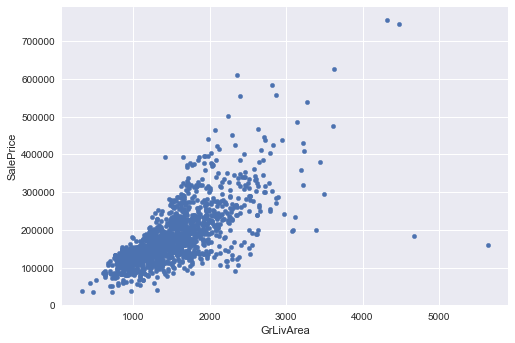

In [148]:
train_df_mod2.plot.scatter(x = 'GrLivArea', y = 'SalePrice')

We define the two points in the far right as outliers and delete them. 

In [149]:
train_df_mod2.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,214,292,0,0,0,480,1,New,Partial,160000
523,524,60,RL,130.0,40094,Pave,IR1,Bnk,AllPub,Inside,...,208,406,0,0,0,0,10,New,Partial,184750


In [150]:
train_df_mod2[train_df_mod2['Id'] == 1299].index

Int64Index([1298], dtype='int64')

In [151]:
train_df_mod2.shape

(1460, 71)

In [153]:
train_df_mod2 = train_df_mod2.drop(train_df_mod2[train_df_mod2['Id'] == 1299].index)

In [154]:
train_df_mod2 = train_df_mod2.drop(train_df_mod2[train_df_mod2['Id'] == 524].index)

In [155]:
train_df_mod2.shape

(1458, 71)

### Statistics time

#### Normality

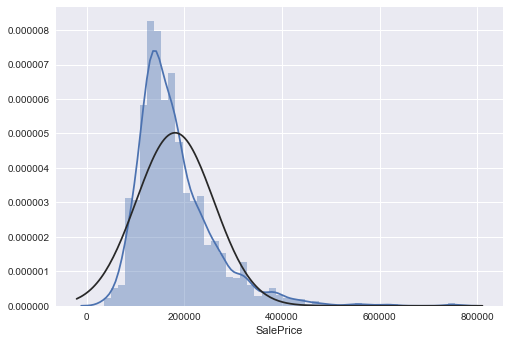

In [156]:
sns.distplot(train_df_mod2['SalePrice'], fit=norm)

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74213.259599766257, 180932.91906721535, 0.93201544928923663))

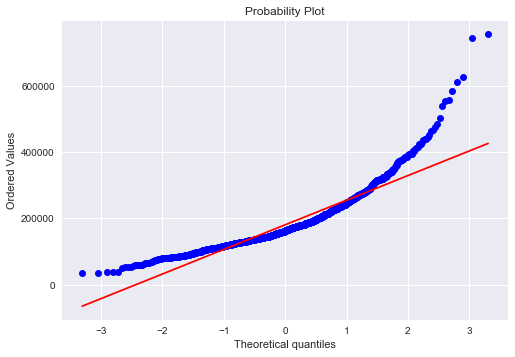

In [157]:
stats.probplot(train_df_mod2['SalePrice'], plot=plt)

More proof that the SalePrice is not normally distributed.  

** In case of positive skewness, a log transformation usually makes the data (pseudo)-normally distributed.**

In [158]:
train_df_mod2['SalePrice'] = np.log(train_df_mod2['SalePrice']) 

Let's look at the distplot and probplot again

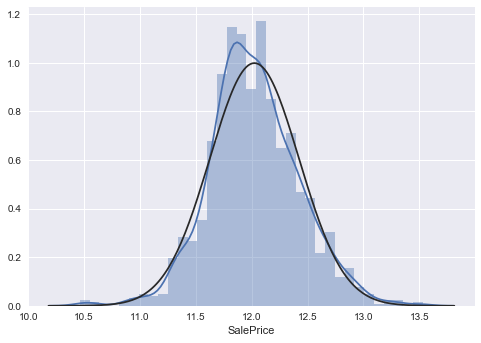

In [159]:
sns.distplot(train_df_mod2['SalePrice'], fit=norm)

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([ 10.46024211,  10.47194981,  10.54270639, ...,  13.34550693,
          13.5211395 ,  13.53447303])),
 (0.39853206929765145, 12.024008660964794, 0.99539186483113717))

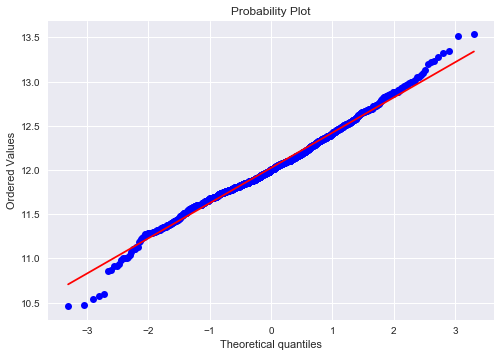

In [160]:
stats.probplot(train_df_mod2.SalePrice, plot = plt)

Much better! Remember, when we get out the predictions from ML algorithms, they will be for log of the houseprice.  We will have to exponentiate them before submitting the answers.

Let's look at the distribution of other features which have a high correlation with SalePrice. 

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([ 334,  438,  480, ..., 3627, 4316, 4476])),
 (495.69423817403663, 1510.465706447188, 0.9743965913979763))

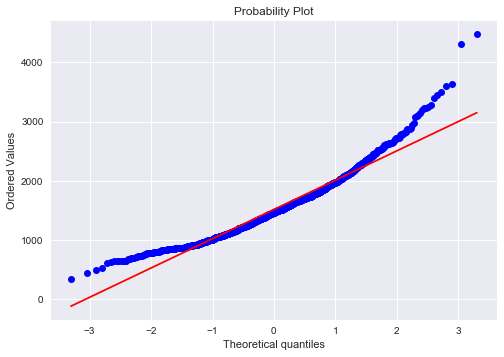

In [161]:
stats.probplot((train_df_mod2['GrLivArea']), plot = plt)

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([ 18.27566688,  20.92844954,  21.9089023 , ...,  60.2245797 ,
          65.69627082,  66.90291473])),
 (6.3115587322598641, 38.343915148698883, 0.99335157945829822))

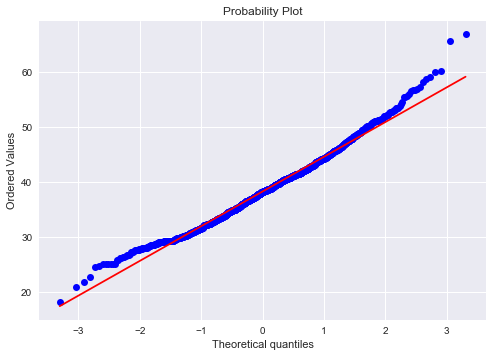

In [162]:
stats.probplot(np.sqrt(train_df_mod2['GrLivArea']), plot = plt)

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([  6.93823207,   7.59436332,   7.82973528, ...,  15.36440873,
          16.28147745,  16.48023345])),
 (1.2454205863337779, 11.33678301967581, 0.99653260311286707))

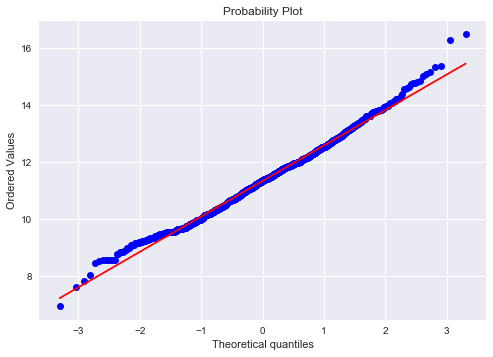

In [163]:
stats.probplot(np.power(train_df_mod2['GrLivArea'], 1.0/3), plot = plt)

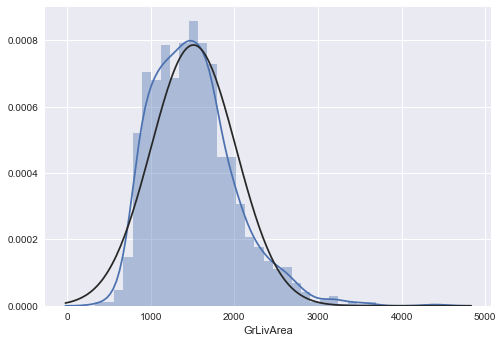

In [164]:
sns.distplot(train_df_mod2['GrLivArea'], fit = norm)

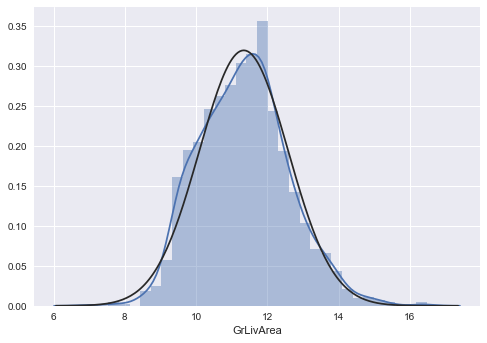

In [165]:
sns.distplot(np.power(train_df_mod2['GrLivArea'], 1./3), fit = norm)

For this variable let's just go with the cube-root transformation

In [166]:
train_df_mod2['GrLivArea'] = np.power(train_df_mod2['GrLivArea'], 1.0/3) 

In [167]:
test_df_mod2['GrLivArea'] = np.power(test_df_mod2['GrLivArea'], 1.0/3) 

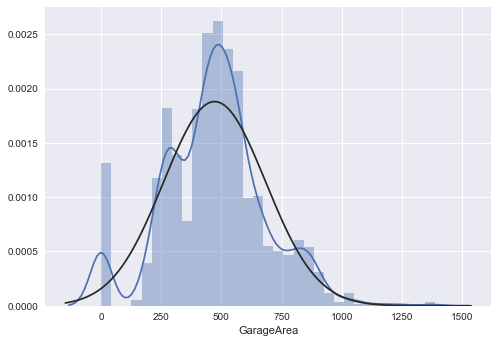

In [168]:
sns.distplot(train_df_mod2['GarageArea'], fit = norm)

In [169]:
corrmat.nlargest(10,'SalePrice')['SalePrice']

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

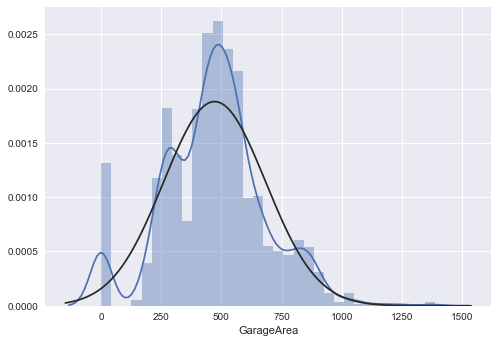

In [170]:
sns.distplot(train_df_mod2['GarageArea'], fit = norm)

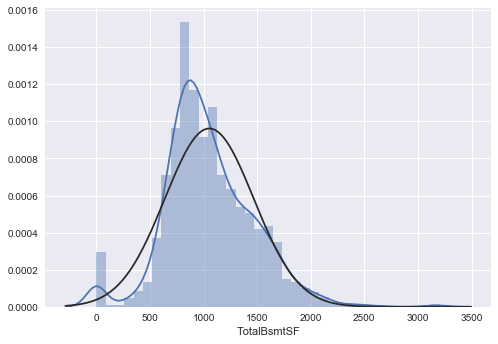

In [171]:
sns.distplot(train_df_mod2['TotalBsmtSF'], fit = norm)

To treat skewness in GarageArea and TotalBsmtSF, we need to address the problem that some houses do not have a Garage or Basement.  Create new features 'HasGarage' and 'HasBsmt' 

In [172]:
train_df_mod2['HasBsmt'] = 0
test_df_mod2['HasBsmt'] = 0
train_df_mod2['HasGarage'] = 0
test_df_mod2['HasGarage'] = 0

In [173]:
train_df_mod2.loc[train_df_mod2['GarageArea'] > 0, 'HasGarage'] = 1
train_df_mod2.loc[train_df_mod2['TotalBsmtSF'] > 0, 'HasBsmt'] = 1
test_df_mod2.loc[test_df_mod2['GarageArea'] > 0, 'HasGarage'] = 1
test_df_mod2.loc[test_df_mod2['TotalBsmtSF'] > 0, 'HasBsmt'] = 1

In [174]:
# This does not work for some reason
#for dataset in combine_mod2:
#    dataset.loc[dataset['GarageArea'] > 0, 'HasGarage'] = 1
#    dataset.loc[dataset['TotalBsmtSF'] > 0, 'HasBsmt'] = 1

In [177]:
train_df_mod2.shape

(1458, 73)

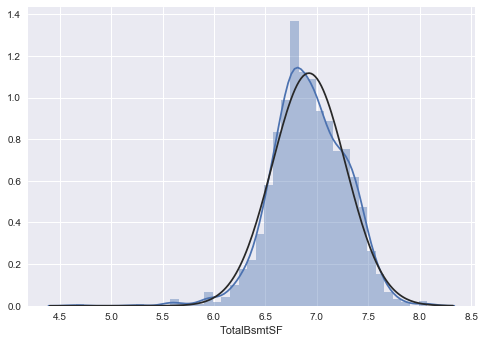

In [178]:
sns.distplot(np.log(train_df_mod2[train_df_mod2['TotalBsmtSF'] > 0]['TotalBsmtSF']), fit = norm)

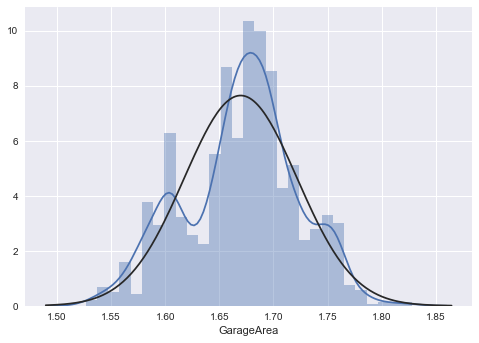

In [179]:
sns.distplot(np.power(train_df_mod2[train_df_mod2['GarageArea'] > 0]['GarageArea'] , 1./12), fit = norm)

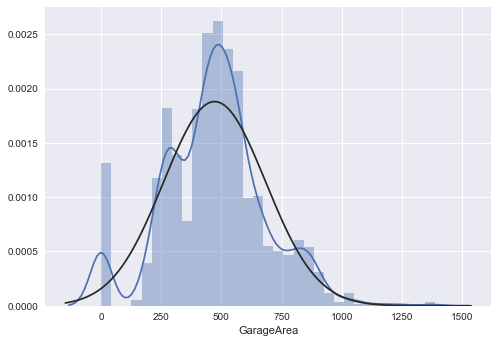

In [180]:
sns.distplot((train_df_mod2[train_df_mod2['GarageArea'] >= 0]['GarageArea']), fit = norm)

Seems like it is difficult to get rid of skewness in GarageArea. So let's get rid of skewness in TotalBsmtSF and call it a day. 

In [181]:
train_df_mod2.loc[train_df_mod2['HasBsmt'] == 1, 'TotalBsmtSF'] = np.log(train_df_mod2['TotalBsmtSF']) 

/home/sushant/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [182]:
test_df_mod2.loc[test_df_mod2['HasBsmt'] == 1, 'TotalBsmtSF'] = np.log(test_df_mod2['TotalBsmtSF']) 

/home/sushant/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


I beleive the message is received, because it tries to take log even when the 'TotalBsmtSF' is 0.  However, this is not a problem because we only store the matrix elements when 'TotalBsmtSF' is != 0. 

In [183]:
train_df_mod2.loc[train_df_mod2['HasBsmt'] == 1][['HasBsmt', 'TotalBsmtSF']].head()

,HasBsmt,TotalBsmtSF
0,1,6.752270
1,1,7.140453
2,1,6.824374
3,1,6.628041
4,1,7.043160


In [184]:
train_df['TotalBsmtSF'].head()

0     856
1    1262
2     920
3     756
4    1145
Name: TotalBsmtSF, dtype: int64

In [185]:
test_df_mod2.loc[test_df_mod2['HasBsmt'] == 0][['HasBsmt', 'TotalBsmtSF']].head()

,HasBsmt,TotalBsmtSF
125,0,0.0
133,0,0.0
269,0,0.0
318,0,0.0
354,0,0.0


In [186]:
train_df_mod2.loc[train_df_mod2['HasBsmt'] == 0][['HasBsmt', 'TotalBsmtSF']].head()

,HasBsmt,TotalBsmtSF
17,0,0.0
39,0,0.0
90,0,0.0
102,0,0.0
156,0,0.0


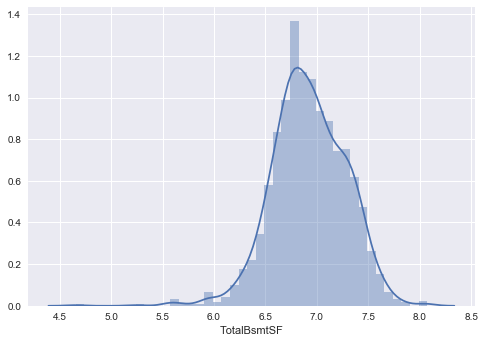

In [187]:
sns.distplot(train_df_mod2.loc[train_df_mod2['HasBsmt'] == 1]['TotalBsmtSF'])

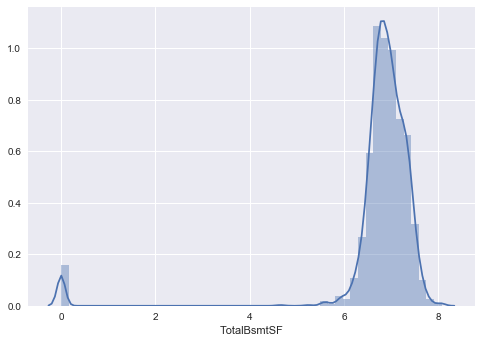

In [188]:
sns.distplot(train_df_mod2['TotalBsmtSF'])

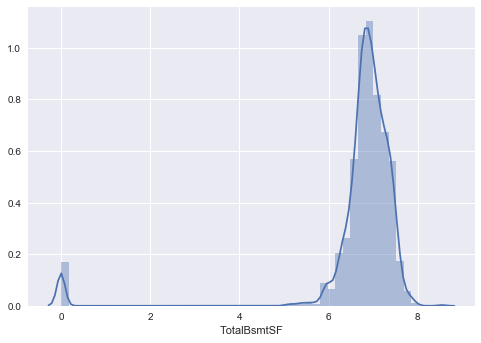

In [189]:
sns.distplot(test_df_mod2['TotalBsmtSF'])

### Homoscedasticity

Homoscedasticity is said to be present, if data has same (similar?) variance around the regression line across the board --> Same variance around the regression line for all values of the predictor variable (X). 

#### Heteroscedasticity:  
If there are subpopulations that have different variabilities from others.  One particular example, the "expanding" cone when the two varaibles are plotted.  See for instance SalePrice and GrLivArea scatter plot way above. 
Heteroscedasticity can invalidate statistical tests of siginificance that assume that the modelling errors are uncorrelated and uniform.

#### some more jargon:
An independent variable, sometimes called an experimental or predictor variable, is a variable that is being manipulated in an experiment in order to observe the effect of a dependent variable, sometimes called an outcome variable.   

The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

Starting by 'SalePrice' and 'GrLivArea'...

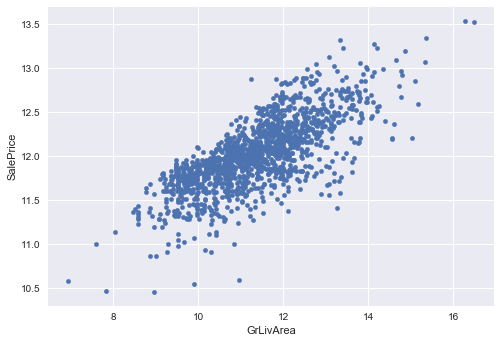

In [190]:
train_df_mod2.plot.scatter(x = 'GrLivArea', y = 'SalePrice')

Note how the plot above is an improvement over the plot below as far homoscedasticity is concerned. This is because of the log transformation.  Taking care of normality takes care of homoscedasticity. 

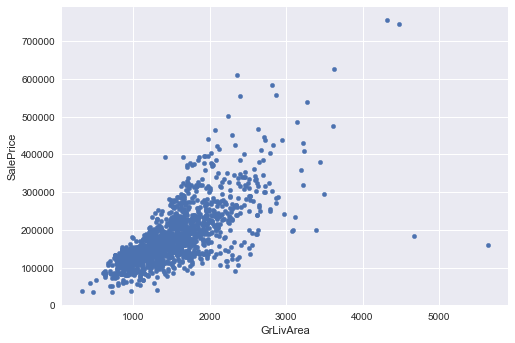

In [191]:
train_df.plot.scatter(x = 'GrLivArea', y = 'SalePrice')

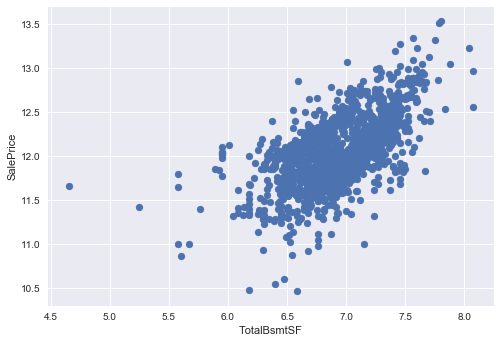

In [192]:
plt.scatter(train_df_mod2[train_df_mod2['HasBsmt'] == 1]['TotalBsmtSF'], \
            train_df_mod2[train_df_mod2['HasBsmt'] == 1]['SalePrice'])
plt.xlabel('TotalBsmtSF')
plt.ylabel('SalePrice')

Homoscedasticity with resepct to TotalBsmtSF check. 

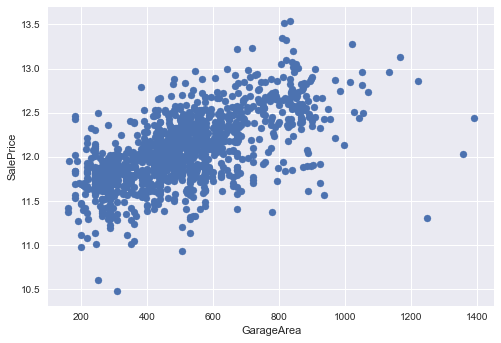

In [193]:
plt.scatter(train_df_mod2[train_df_mod2['HasGarage'] == 1]['GarageArea'], \
            train_df_mod2[train_df_mod2['HasGarage'] == 1]['SalePrice'])
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')

Interestingly enough, GarageArea and SalePrice don't deviate much from homoscedaasticity.  Even though GarageArea is not normally distributed.

### Coverting string features to integers

I don't like what get_dummies does! It creates more features according to values of categorical variable.  LabelEncoder seems more appropriate to what we want to do.

In [195]:
train_df_mod2.select_dtypes(include = ['object']).columns

Index([u'MSZoning', u'Street', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'ExterQual',
       u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond', u'BsmtExposure',
       u'BsmtFinType1', u'BsmtFinType2', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'KitchenQual', u'Functional',
       u'GarageType', u'GarageFinish', u'GarageQual', u'GarageCond',
       u'PavedDrive', u'SaleType', u'SaleCondition'],
      dtype='object')

In [196]:
train_df_mod2.select_dtypes(include = ['object']).columns.shape

(38,)

In [197]:
train_df_mod2.select_dtypes(include = ['int64']).columns.shape

(29,)

In [198]:
train_df_mod2.select_dtypes(include = ['float64']).columns.shape

(6,)

In [199]:
le = preprocessing.LabelEncoder()

In [200]:
train_df_mod2['SaleType'].unique()

array(['WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth'], dtype=object)

In [201]:
le.fit(train_df_mod2['SaleType'].unique())

LabelEncoder()

Let's apply LabelEncoding transformation to all columns at once. 

In [205]:
for col in train_df_mod2.select_dtypes(include = ['object']).columns:
    le.fit(train_df_mod2[col].unique())
    train_df_mod2.loc[:, col] = le.transform(train_df_mod2[col])

In [206]:
for col in test_df_mod2.select_dtypes(include = ['object']).columns:
    le.fit(test_df_mod2[col].unique())
    test_df_mod2.loc[:, col] = le.transform(test_df_mod2[col])

In [207]:
train_df_mod2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 73 columns):
Id               1458 non-null int64
MSSubClass       1458 non-null int64
MSZoning         1458 non-null int64
LotFrontage      1458 non-null float64
LotArea          1458 non-null int64
Street           1458 non-null int64
LotShape         1458 non-null int64
LandContour      1458 non-null int64
Utilities        1458 non-null int64
LotConfig        1458 non-null int64
LandSlope        1458 non-null int64
Neighborhood     1458 non-null int64
Condition1       1458 non-null int64
Condition2       1458 non-null int64
BldgType         1458 non-null int64
HouseStyle       1458 non-null int64
OverallQual      1458 non-null int64
OverallCond      1458 non-null int64
YearBuilt        1458 non-null int64
YearRemodAdd     1458 non-null int64
RoofStyle        1458 non-null int64
RoofMatl         1458 non-null int64
Exterior1st      1458 non-null int64
Exterior2nd      1458 non-null int64
Mas

In [208]:
test_df_mod2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 72 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1459 non-null int64
LotFrontage      1459 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null int64
LotShape         1459 non-null int64
LandContour      1459 non-null int64
Utilities        1459 non-null int64
LotConfig        1459 non-null int64
LandSlope        1459 non-null int64
Neighborhood     1459 non-null int64
Condition1       1459 non-null int64
Condition2       1459 non-null int64
BldgType         1459 non-null int64
HouseStyle       1459 non-null int64
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null int64
RoofMatl         1459 non-null int64
Exterior1st      1459 non-null int64
Exterior2nd      1459 non-null int64
Mas

Everything is either a a float or integer.  We are finally ready to apply ML algorithms!

## Fitting models

Starting with vanilla version random forest.  Not changing any parameters. 

In [ ]:
X_train = train_df_mod2.drop('SalePrice', axis = 1)
Y_train = train_df_mod2['SalePrice']

In [ ]:
RFR = RandomForestRegressor()
RFR.fit(X_train, Y_train)
accRFC = round(RFR.score(X_train, Y_train), 4)
accRFC

In [ ]:
RFR_predict_simple = RFR.predict(test_df_mod2)

In [ ]:
RFR_predict_simple

In [ ]:
RFR_actual_price = np.exp(RFR_predict_simple)

In [ ]:
RFR_actual_price

In [ ]:
submission_RFR_simple = pd.DataFrame({
    'Id':test_df_mod2.Id,
    'SalePrice': RFR_actual_price
})

In [ ]:
submission_RFR_simple.head()

In [ ]:
#submission_RFR_simple.to_csv('./predictions/randomForestRegressorMostBasic.csv', index = False)
# gives the score of 0.16196

Realized that I left the 'Id' feature.  It should obviously have no effect on the SalePrice, eggting rid of it

In [ ]:
train_df_mod2['Id'].head()

In [ ]:
test_df_mod2['Id'].head()

Dropping the 'Id' feature

In [ ]:
X_train = train_df_mod2.drop(['SalePrice', 'Id'], axis = 1)
Y_train = train_df_mod2['SalePrice']

In [ ]:
RFR = RandomForestRegressor()
RFR.fit(X_train, Y_train)
accRFC = round(RFR.score(X_train, Y_train), 4)
accRFC

In [ ]:
X_test = test_df_mod2.drop('Id', axis = 1)

In [ ]:
RFR_predict_simple = RFR.predict(X_test)

In [ ]:
RFR_predict_simple

In [ ]:
RFR_actual_price = np.exp(RFR_predict_simple)

In [ ]:
RFR_actual_price

In [ ]:
submission_RFR_simple = pd.DataFrame({
    'Id':test_df_mod2.Id,
    'SalePrice': RFR_actual_price
})

In [ ]:
submission_RFR_simple.head()

In [ ]:
#submission_RFR_simple.to_csv('./predictions/randomForestRegressorMostBasicDropID.csv', index = False)
# gives the score of 0.16569

Including Cross validation

In [ ]:
RFR = RandomForestRegressor(n_estimators=100, n_jobs = -1)
RFR.fit(X_train, Y_train)
cross_val_score(RFR, X_train, Y_train)

In [ ]:
RFR = RandomForestRegressor(n_estimators=100, \
                            n_jobs = -1)
RFR.fit(X_train, Y_train)
cross_val_score(RFR, X_train, Y_train)

In [ ]:
np.sort(RFR.feature_importances_)[::-1]

In [ ]:
coefRFR = pd.Series(RFR.feature_importances_, index = X_train.columns).sort_values()

In [ ]:
coefRFR.tail()

In [ ]:
coefRFR.tail(10).plot(kind = 'barh')

In [ ]:
corrmat.nlargest(9, 'SalePrice')['SalePrice']

In [ ]:
X_train.loc[:, RFR.feature_importances_ > 0.01].columns

In [ ]:
X_train.loc[:, RFR.feature_importances_ > 0.5].columns

In [ ]:
RFR_predict_CV = RFR.predict(X_test)

In [ ]:
RFR_predict_CV

In [ ]:
RFR_actual_price_CV = np.exp(RFR_predict_CV)

In [ ]:
RFR_actual_price_CV

In [ ]:
submission_RFR_CV = pd.DataFrame({
    'Id':test_df_mod2.Id,
    'SalePrice': RFR_actual_price_CV
})

In [ ]:
submission_RFR_CV.head()

In [ ]:
#submission_RFR_CV.to_csv('./predictions/randomForestRegressorMostBasicDropIDCrossValidation100trees.csv', index = False)
# gives the score of 0.15247

200 trees give a score of 0.15247, 100 trees give a score of 0.15433

Let's try gradient boosting

In [ ]:
GB = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, subsample= 0.85)
GB.fit(X_train, Y_train)
cross_val_score(GB, X_train, Y_train)

In [ ]:
GB = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2, subsample= 0.8)
GB.fit(X_train, Y_train)
cross_val_score(GB, X_train, Y_train)

In [ ]:
GB = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber')
GB.fit(X_train, Y_train)
cross_val_score(GB, X_train, Y_train)

In [ ]:
GB = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber')
GB.fit(X_train, Y_train)
cross_val_score(GB, X_train, Y_train)

In [ ]:
coef = pd.Series(GB.feature_importances_, index = X_train.columns).sort_values(ascending = False)

In [ ]:
coef.head(12)

In [ ]:
coef.head(20) #with 3000 estimators

In [ ]:
GB_predict_CV = GB.predict(X_test)

In [ ]:
GB_predict_CV

In [ ]:
GB_actual_price_CV = np.exp(GB_predict_CV)

In [ ]:
GB_actual_price_CV

In [ ]:
submission_GB_CV = pd.DataFrame({
    'Id':test_df_mod2.Id,
    'SalePrice': GB_actual_price_CV
})

In [ ]:
submission_GB_CV.head()

In [ ]:
submission_GB_CV.to_csv('./predictions/GradientBoostingDropIDCrossValidation3000-0p05-huberRandDefault.csv', index = False)
# gives the score of 0.13249

100, 0.1, 0.8 gave a score of 0.14483 (the best, I've so far)

In [ ]:
GB.feature_importances_

In [ ]:
train_df.select_dtypes(include = ['object']).columns

In [ ]:
train_df[]

Support Vector Machines

In [ ]:
svr = SVR(C = 0.1)
svr.fit(X_train, Y_train)
cross_val_score(svr, X_train, Y_train)

In [ ]:
SV_predict_CV = svr.predict(X_test)

In [ ]:
SV_predict_CV

In [ ]:
SV_actual_price_CV = np.exp(SV_predict_CV)
SV_actual_price_CV

Looks like the Support Vector Machine doesn't work.  Most likely it is because the features we have here are mixed (combination of continuous and categorical values). 

In [ ]:
GB_actual_price_CV

Let's look at the prediction on the test set

In [ ]:
RFRpred = RFR.predict(X_train)
GBpred = GB.predict(X_train)

In [ ]:
# visualize predicted values versus true values
plt.scatter(Y_train, RFRpred, c='b', marker='x');
plt.scatter(Y_train, GBpred, c='r', marker='*');
plt.scatter(Y_train, Y_train, c='g', marker='+');
plt.xlabel('True House Prices');
plt.legend(('Random Forest', 'Gradient Boosting', 'True value'));